In [1]:
%matplotlib inline
#from bokeh.io import output_notebook
#rom bokeh.plotting import *
from matmodlab2 import *
from numpy import *
#output_notebook()
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import dill
import sys
from numpy import cos, sin
from sklearn.linear_model import LinearRegression
from wccm_support import plot_Y_components
import matplotlib.tri as tri

Setting up the Matmodlab notebook environment


In [2]:
def align_pi_plane_with_axes_rot():
    """
    Returns a matrix that rotates the pi plane's normal to be the z axis
    i.e., a slice of pi plane becomes the xy plane after rotation
    """
    pi_vector = np.array([1, 1, 1]) / np.sqrt(3.)
    # wanted_vector = np.array([1, 0, 0])
    wanted_vector = np.array([0, 0, 1])
    wanted_vector = wanted_vector / np.linalg.norm(wanted_vector)
    added = (pi_vector + wanted_vector).reshape([-1, 1])
    # from Rodrigues' rotation formula, more info here: https://math.stackexchange.com/a/2672702
    rot_mat = 2 * (added @ added.T) / (added.T @ added) - np.eye(3)
    return rot_mat


def align_axes_with_pi_plane_rot():
    """
    Returns a matrix that undoes the align_pi_plane_with_axes_rot rotation
    """
    return np.linalg.inv(align_pi_plane_with_axes_rot())

align_axes_with_pi_plane_rot = align_axes_with_pi_plane_rot()
align_pi_plane_with_axes_rot = align_pi_plane_with_axes_rot()

def run_ST_GPSR_TTM(property_dict, loads='ESS', components=(0.02, 0, 0), frames=50):
    mps1 = MaterialPointSimulator('ST_GPSR_TTM')
    mps1.material = ST_GPSR_TTM(**property_dict)
    mps1.run_step(loads,  components, frames=frames)
    return mps1

def draw_principal_axes(ax, length_of_axes=2.5, scale=100):
    """
    Draws principal axes on graph, change length of axes and scale
    """
    zero_pos = np.zeros(2)
    straight_up_pos = np.array([0, 1]) * length_of_axes
    bottom_right_pos = np.array([np.cos(-np.pi / 6.), np.sin(-np.pi / 6.)]) * length_of_axes
    bottom_left_pos = np.array([np.cos(7 * np.pi / 6.), np.sin(7 * np.pi / 6.)]) * length_of_axes

    ax.quiver(*zero_pos, *straight_up_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_2$", straight_up_pos + np.array([0.25, -0.3]) * scale)

    ax.quiver(*zero_pos, *bottom_right_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_1$", bottom_right_pos + np.array([-0.18, 0.45]) * scale)

    ax.quiver(*zero_pos, *bottom_left_pos, scale_units="xy", scale=1)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.1, -0.45]) * scale)
    ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.28, -0.4]) * scale)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([-0.18, -0.4]) * scale)

In [3]:
#""" Force deviatoric independence on a BINGO solution
def A_mapping(real_eqps  ):

    B_in = ((array(0.19468542))/(real_eqps + array(0.19468542)) ) * (array([[-0.78883927, -0.17774928,  0.05046644],
       [-0.94038756, -0.01281956,  0.0229076 ],
       [-0.80953323, -0.10425625, -0.02368224]]))
    #B_in *= (ISO_Y_0 + ISO_H*fict_eqps)
    B_in = align_axes_with_pi_plane_rot.T @ B_in @ align_axes_with_pi_plane_rot
    B_in[:, 2] = 0
    B_in[2, :] = 0
    B_in[2, 2] = 1
    B_in = align_axes_with_pi_plane_rot @ B_in @ align_axes_with_pi_plane_rot.T
    new_B = np.zeros((6,6))
    new_B[0:3, 0:3] = B_in
    new_B[3:, 3:] = np.eye(3) # Like the stuffness matrix, the shear comps are multiplied by ROOT2
    return new_B
#"""

# Shared params
E = 10e3
nu = .333


# Build the loading paths
rotation_angles = np.linspace(0,2*np.pi, 36)
axial_E = 0.3

pairs = [( 0, 1, 2 ), ( 1, 2, 0 ), ( 0, 2, 1 )]
load_string = [ 'EES', 'SEE', 'ESE' ]
pair_comps = [] 

load_comps = []
for i, pair in enumerate(pairs):
    local_comps = []
    local_load_comps = []
    a1 = pair[0]
    a2 = pair[1]
    s_index = pair[2]

    for ang in rotation_angles:
        local_load_comps.append(load_string[i])
        load_reference = [ 0, 0, 0 ]
        load_reference[a1] = axial_E * np.cos(ang)
        load_reference[a2] = axial_E * np.sin(ang)
        load_reference[s_index] = 0
        #print(F_reference)
        #rotation = rotations[rot](ang)
        # F_reference = F_reference.reshape(3,3)
        # F = np.dot(rotation, F_reference)
        # F = tuple(F.flatten())
        local_comps.append(load_reference)
    pair_comps.append(local_comps)
    load_comps.append(local_load_comps)

all_frames = 100

In [4]:
run = True
if run:
    results = []
    for comps_summary, load_summary in zip(pair_comps, load_comps):
        comp_results = []
        for comps, load in zip(comps_summary, load_summary):
            # Run ST_GPSR_TTM model
            pGPSR = {'E': E, 'Nu': nu,  "A_mapping": A_mapping}
            #print(comps, all_loads)
            try:
                mpsGPSR = run_ST_GPSR_TTM(pGPSR, frames=all_frames, components=comps, loads=load)
            except Exception as e:
                print(f'Failed on {comps_summary} and {load_summary}')
                print(e)
                continue
            comp_results.append(mpsGPSR)
        results.append(comp_results)


    with open("hill_results.pkl", "wb") as dill_file:
        dill.dump(results, dill_file)
else:
    with open("hill_results.pkl", "rb") as dill_file:
        results = dill.load(dill_file)



<AxesSubplot:xlabel='$\\sigma_{11}$', ylabel='$\\sigma_{33}$'>

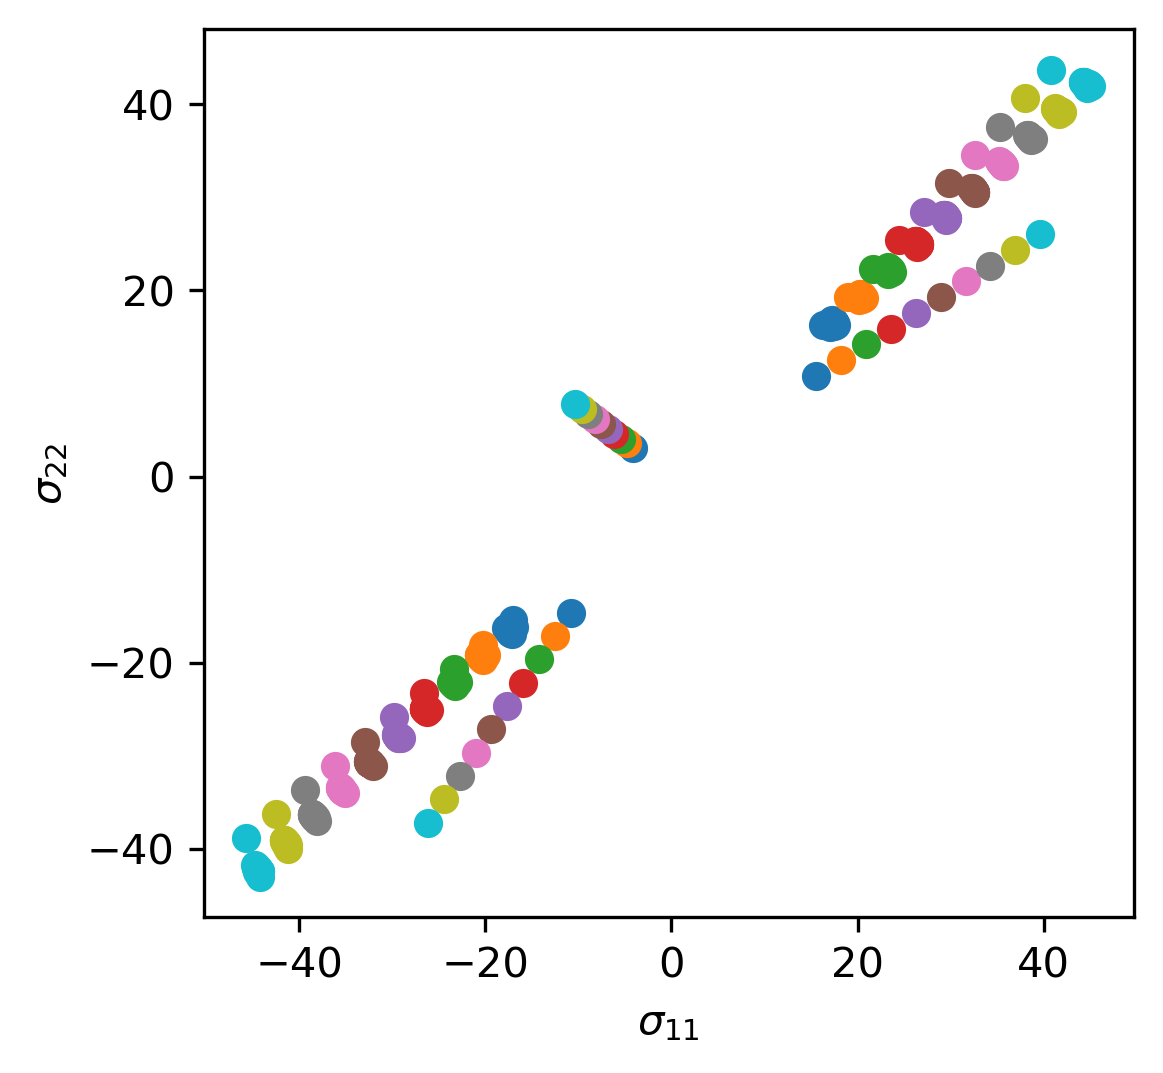

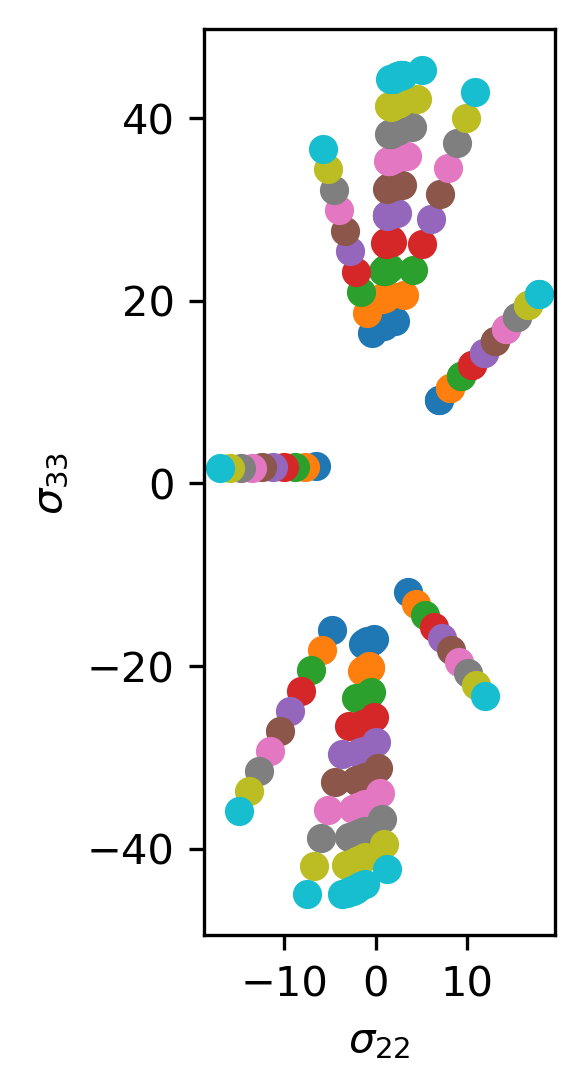

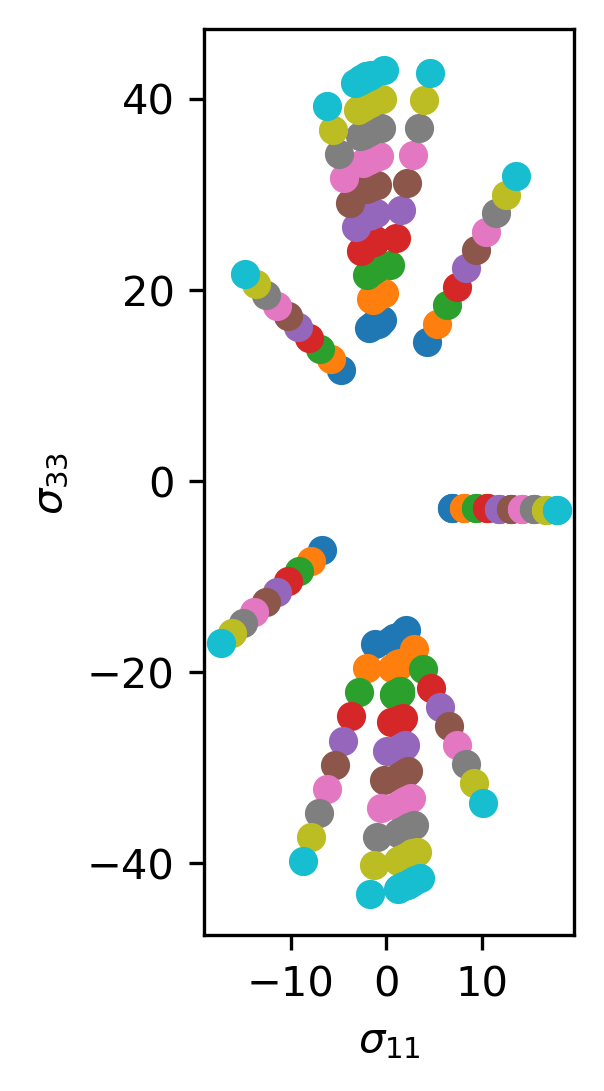

In [5]:
eqps_vals = np.linspace(0, 0.3, 10)#np.array([0.000625*i for i in range(8) ])

plot_Y_components(results[0], pairs[0], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{22}$'])
plot_Y_components(results[1], pairs[1], eqps_vals, ['$\\sigma_{22}$', '$\\sigma_{33}$'])
plot_Y_components(results[2], pairs[2], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{33}$'])

In [6]:
import sympy as sp
sp.init_printing(use_latex='mathjax')
X_0 = sp.Symbol('\\varepsilon_p')
#equation = sp.Matrix()
print(pkl.hall_of_fame[0])

NameError: name 'pkl' is not defined

In [ ]:
equation = sp.Matrix((array([[ 0.18624771, -1.05351908,  1.09630422],
       [ 0.30885821, -1.20627084,  1.14489533],
       [ 0.15340692, -1.07458746,  1.17054264]])) * ((X_0)/(X_0 + array(0.19481503)) ) + array([[ 0.86850001, -0.29985752,  0.05247781],
       [ 0.74582105, -0.14716585,  0.00385973],
       [ 0.90154855, -0.27851871, -0.02146833]])
)
v = sp.Matrix(align_axes_with_pi_plane_rot.T @ sp.expand(equation*(1000 + 990*X_0)) @ align_axes_with_pi_plane_rot)
v[0, 2] = 0 
v[2, 0] = 0
v[1, 2] = 0 
v[2, 1] = 0
v[2, 2] = 1
v = align_axes_with_pi_plane_rot @ v @ align_axes_with_pi_plane_rot.T
v

In [ ]:
print(pkl.hall_of_fame)

In [ ]:
print(sp.printing.latex( ((array(0.19468542))/(X_0 + array(0.19468542))    )))

In [ ]:
print(sp.printing.latex(sp.Matrix(  (array([[-0.78883927, -0.17774928,  0.05046644],
       [-0.94038756, -0.01281956,  0.0229076 ],
       [-0.80953323, -0.10425625, -0.02368224]]))   )))

In [ ]:
print(sp.printing.latex(sp.Matrix(array([[ 0.86850001, -0.29985752,  0.05247781],
       [ 0.74582105, -0.14716585,  0.00385973],
       [ 0.90154855, -0.27851871, -0.02146833]]))))

In [ ]:
# For each results array, let' find the error between the predicted value and the analytical
def hill_YS(stress_vector, eqps, F=1., G=0.3, H=7.):
    analytical_Y = (13.6208515706149 + 69.9208533115855*eqps)
    sigma_1 = stress_vector[0]
    sigma_2 = stress_vector[1]
    sigma_3 = stress_vector[2]
    simulation_Y = np.sqrt(1./2.)*np.sqrt(F * (sigma_2 - sigma_3)**2 + G * (sigma_3 - sigma_1)**2 + H*(sigma_1 - sigma_2)**2 )

    error = np.abs((simulation_Y - analytical_Y)/analytical_Y)*100
    print(simulation_Y, analytical_Y, eqps)
    return error, analytical_Y, simulation_Y


def plot_error_contour(set_of_results, components, eqps_to_plot, labels, ax = None):
    eqps_panda = pd.DataFrame(eqps_to_plot, columns=['REAL_EQPS'])
    if ax == None:
        f, ax = plt.subplots(figsize=(4, 4), dpi=300)
    dataset = [ ]

    
    for mps in set_of_results:
        stress_history = mps.df[['S.XX', 'S.YY', 'S.ZZ', 'REAL_EQPS']]

        #mps.plot('E.XX', 'S.XX')

        stress_history = stress_history[stress_history['REAL_EQPS'] > 1e-6]

        regressorSXX = LinearRegression()
        regressorSXX.fit(stress_history[['REAL_EQPS']], stress_history[['S.XX']])

        regressorSYY = LinearRegression()
        regressorSYY.fit(stress_history[['REAL_EQPS']], stress_history[['S.YY']])

        regressorSZZ = LinearRegression()
        regressorSZZ.fit(stress_history[['REAL_EQPS']], stress_history[['S.ZZ']])

        SXX = regressorSXX.predict(eqps_panda)
        SYY = regressorSYY.predict(eqps_panda)
        SZZ = regressorSZZ.predict(eqps_panda)
        for _, eqps in enumerate(eqps_to_plot):
            #print(_)
            errors, __, ___ = hill_YS(np.array([SXX[_], SYY[_], SZZ[_]]), eqps)
            dataset.append([SXX[_], SYY[_], SZZ[_], errors])
    dataset = np.array(dataset)
    print(dataset[:,components[0]].shape, dataset[:,components[1]].shape)
    plt.scatter(dataset[:,components[0]].flatten(), dataset[:,components[1]].flatten(), c=dataset[:,3].flatten())
    plt.colorbar()


    ax.set_xlabel(f'{labels[0]}')
    ax.set_ylabel(f'{labels[1]}')
    ax.set_aspect('equal', adjustable='box')


plot_error_contour(results[0], pairs[0], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{22}$'])
plot_error_contour(results[1], pairs[1], eqps_vals, ['$\\sigma_{22}$', '$\\sigma_{33}$'])
plot_error_contour(results[2], pairs[2], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{33}$'])

In [ ]:
ax = plot_Y_components(results[0], pairs[0], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{22}$'])
plot_error_contour(results[0], pairs[0], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{22}$'], ax=ax)